# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#!pip install torch
#!pip install torchvision

import os
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms


from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR

np.random.seed(69)

In [3]:
# Check Torch version
torch. __version__

'1.13.0+cu117'

In [4]:
torchvision. __version__

'0.14.0+cu117'

# Load Data and Split into Train & Test

In [5]:
#dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
#download_url(dataset_url, '.')
#with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    #tar.extractall(path='./data')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size*2, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Use CUDA

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA


# CNN Model Architecture

In [7]:
def ConvLayer(inp, out, ks=3, s=1, p=1):
    return nn.Conv2d(inp, out, kernel_size=ks, stride=s, padding=p)
class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural_net = nn.Sequential(
            ConvLayer(3, 32), nn.ReLU(),
            ConvLayer(32, 64), nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            ConvLayer(64, 128), nn.ReLU(),
            ConvLayer(128, 256), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ConvLayer(256, 512), nn.ReLU(),
            ConvLayer(512, 1024), nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Flatten(),
            nn.Linear(1024*4*4, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        return self.neural_net(x)

In [8]:
def accuracy_score(out, labels):
    _, preds = torch.max(out, dim=1)
    correct_preds = torch.sum(preds==labels).item()
    total_preds = len(preds)
    accuracy = torch.tensor(correct_preds/total_preds)
    return accuracy

https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

# Variables

In [9]:
num_epochs = 15
learning_rate=0.1
epochs = np.arange(1,num_epochs+1,1)

# Adam Optimizer

In [10]:
%%time

model = CIFAR10().to(device)
train_acc_adam=[]
test_acc_adam=[]
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)

for epoch in range(num_epochs):
    total_training_accuracies = []
    total_testing_accuracies = []
    for img, labels in train_loader:
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        metrics = accuracy_score(pred, labels)
        total_training_accuracies.append(metrics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
    train_acc_adam.append(sum(total_training_accuracies)/len(total_training_accuracies))
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc_adam.append(sum(total_testing_accuracies)/len(total_testing_accuracies))

Epoch Number:  1  | Training Accuracy Score:  tensor(0.4074)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.5005)
Epoch Number:  2  | Training Accuracy Score:  tensor(0.5766)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.6256)
Epoch Number:  3  | Training Accuracy Score:  tensor(0.6810)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.7010)
Epoch Number:  4  | Training Accuracy Score:  tensor(0.7531)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.7490)
Epoch Number:  5  | Training Accuracy Score:  tensor(0.8022)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.7589)
Epoch Number:  6  | Training Accuracy Score:  tensor(0.8488)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.7872)
Epoch Number:  7  | Training Accuracy Score:  tensor(0.8918)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.7921)
Epoch Number:  8  | Training Accuracy Score:  tensor(0.9264)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.7698)
Epoch Number:  9  | Training Acc

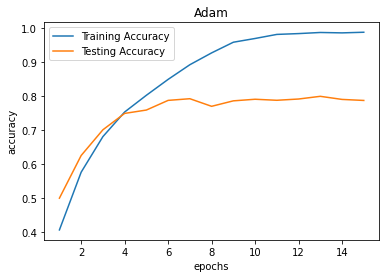

In [11]:
plt.title("Adam")
plt.plot(epochs, train_acc_adam, label='Training Accuracy')
plt.plot(epochs, test_acc_adam, label='Testing Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# SGD Optimizer: lr = 0.1

In [31]:
%%time

model = CIFAR10().to(device)

train_acc_sgd1=[]
test_acc_sgd1=[]

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate)
for epoch in range(num_epochs):
    total_training_accuracies = []
    total_testing_accuracies = []
    for img, labels in train_loader:
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        metrics = accuracy_score(pred, labels)
        total_training_accuracies.append(metrics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
    train_acc_sgd1.append(sum(total_training_accuracies)/len(total_training_accuracies))
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc_sgd1.append(sum(total_testing_accuracies)/len(total_testing_accuracies))

Epoch Number:  1  | Training Accuracy Score:  tensor(0.1206)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.2151)
Epoch Number:  2  | Training Accuracy Score:  tensor(0.2723)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.3644)
Epoch Number:  3  | Training Accuracy Score:  tensor(0.3943)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.4382)
Epoch Number:  4  | Training Accuracy Score:  tensor(0.4906)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.5552)
Epoch Number:  5  | Training Accuracy Score:  tensor(0.5666)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.5583)
Epoch Number:  6  | Training Accuracy Score:  tensor(0.6394)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.6381)
Epoch Number:  7  | Training Accuracy Score:  tensor(0.7024)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.6642)
Epoch Number:  8  | Training Accuracy Score:  tensor(0.7568)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.7162)
Epoch Number:  9  | Training Acc

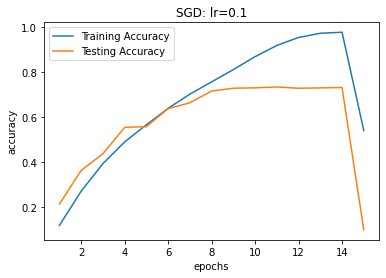

In [32]:
plt.title("SGD: lr=0.1")
plt.plot(epochs, train_acc_sgd1, label='Training Accuracy')
plt.plot(epochs, test_acc_sgd1, label='Testing Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# SGD Optimizer: lr=0.01 & Momentum=0.5

In [14]:
%%time

model = CIFAR10().to(device)
train_acc_sgd2=[]
test_acc_sgd2=[]
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr= 0.01, momentum = 0.5)

for epoch in range(num_epochs):
    total_training_accuracies = []
    total_testing_accuracies = []
    for img, labels in train_loader:
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        metrics = accuracy_score(pred, labels)
        total_training_accuracies.append(metrics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
    train_acc_sgd2.append(sum(total_training_accuracies)/len(total_training_accuracies))
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc_sgd2.append(sum(total_testing_accuracies)/len(total_testing_accuracies))

Epoch Number:  1  | Training Accuracy Score:  tensor(0.1015)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.0991)
Epoch Number:  2  | Training Accuracy Score:  tensor(0.1034)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.1021)
Epoch Number:  3  | Training Accuracy Score:  tensor(0.1099)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.1693)
Epoch Number:  4  | Training Accuracy Score:  tensor(0.1734)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.1675)
Epoch Number:  5  | Training Accuracy Score:  tensor(0.1879)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.2552)
Epoch Number:  6  | Training Accuracy Score:  tensor(0.2670)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.2856)
Epoch Number:  7  | Training Accuracy Score:  tensor(0.3239)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.3541)
Epoch Number:  8  | Training Accuracy Score:  tensor(0.3755)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.4029)
Epoch Number:  9  | Training Acc

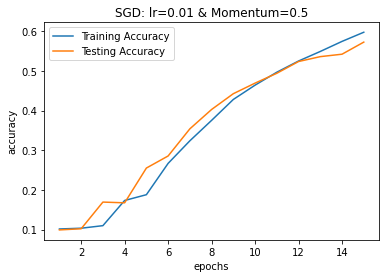

In [15]:
plt.title("SGD: lr=0.01 & Momentum=0.5")
plt.plot(epochs, train_acc_sgd2, label='Training Accuracy')
plt.plot(epochs, test_acc_sgd2, label='Testing Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# SGD Optimizer: lr=0.1 & Momentum=0.5 & Weight Decay=0.01/100


In [16]:
%%time

model = CIFAR10().to(device)
train_acc_sgd3=[]
test_acc_sgd3=[]
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate, momentum = 0.5, weight_decay=0.01/100)

for epoch in range(num_epochs):
    total_training_accuracies = []
    total_testing_accuracies = []
    for img, labels in train_loader:
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        metrics = accuracy_score(pred, labels)
        total_training_accuracies.append(metrics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
    train_acc_sgd3.append(sum(total_training_accuracies)/len(total_training_accuracies))
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc_sgd3.append(sum(total_testing_accuracies)/len(total_testing_accuracies))

Epoch Number:  1  | Training Accuracy Score:  tensor(0.1553)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.2620)
Epoch Number:  2  | Training Accuracy Score:  tensor(0.3615)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.4464)
Epoch Number:  3  | Training Accuracy Score:  tensor(0.5115)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.5393)
Epoch Number:  4  | Training Accuracy Score:  tensor(0.6264)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.6450)
Epoch Number:  5  | Training Accuracy Score:  tensor(0.7159)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.6929)
Epoch Number:  6  | Training Accuracy Score:  tensor(0.7776)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.7512)
Epoch Number:  7  | Training Accuracy Score:  tensor(0.8393)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.7734)
Epoch Number:  8  | Training Accuracy Score:  tensor(0.8883)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.7831)
Epoch Number:  9  | Training Acc

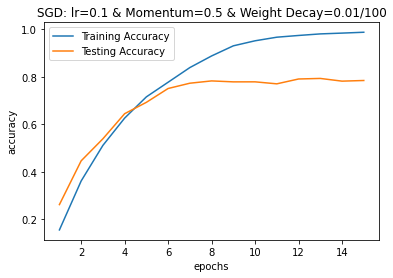

In [17]:
plt.title("SGD: lr=0.1 & Momentum=0.5 & Weight Decay=0.01/100")
plt.plot(epochs, train_acc_sgd3, label='Training Accuracy')
plt.plot(epochs, test_acc_sgd3, label='Testing Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# SGD Optimizer: lr=0.1 & Momentum=0.5 & Dampening = 0.5


In [18]:
%%time

model = CIFAR10().to(device)
train_acc_sgd4=[]
test_acc_sgd4=[]
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate, momentum=0.5)

for epoch in range(num_epochs):
    total_training_accuracies = []
    total_testing_accuracies = []
    for img, labels in train_loader:
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        metrics = accuracy_score(pred, labels)
        total_training_accuracies.append(metrics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
    train_acc_sgd4.append(sum(total_training_accuracies)/len(total_training_accuracies))
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc_sgd4.append(sum(total_testing_accuracies)/len(total_testing_accuracies))

Epoch Number:  1  | Training Accuracy Score:  tensor(0.1370)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.2354)
Epoch Number:  2  | Training Accuracy Score:  tensor(0.3376)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.4101)
Epoch Number:  3  | Training Accuracy Score:  tensor(0.4976)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.5311)
Epoch Number:  4  | Training Accuracy Score:  tensor(0.6162)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.6686)
Epoch Number:  5  | Training Accuracy Score:  tensor(0.7076)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.7097)
Epoch Number:  6  | Training Accuracy Score:  tensor(0.7811)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.7491)
Epoch Number:  7  | Training Accuracy Score:  tensor(0.8428)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.7644)
Epoch Number:  8  | Training Accuracy Score:  tensor(0.8985)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.7685)
Epoch Number:  9  | Training Acc

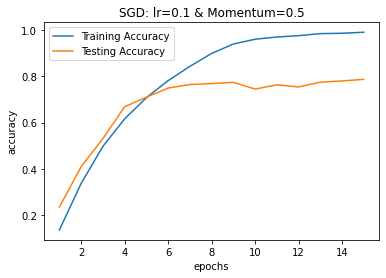

In [19]:
plt.title("SGD: lr=0.1 & Momentum=0.5")
plt.plot(epochs, train_acc_sgd4, label='Training Accuracy')
plt.plot(epochs, test_acc_sgd4, label='Testing Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# SGD Optimizer: Time Based Decay for Learning Rate


In [20]:
# %%time

# model = CIFAR10().to(device)

# train_acc_sgd5=[]
# test_acc_sgd5=[]

# learning_rate = 0.1
# decay_rate = learning_rate / 2*num_epochs
# momentum = 0.5
# loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=decay_rate)
# for epoch in range(num_epochs):
#     total_training_accuracies = []
#     total_testing_accuracies = []
#     for img, labels in train_loader:
#         img = img.to(device)
#         labels = labels.to(device)
#         pred = model(img)
#         loss = loss_func(pred, labels)
#         metrics = accuracy_score(pred, labels)
#         total_training_accuracies.append(metrics)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
#     train_acc_sgd5.append(sum(total_training_accuracies)/len(total_training_accuracies))
#     for test_img, test_labels in test_loader:
#         test_img = test_img.to(device)
#         test_labels = test_labels.to(device)
#         test_preds = model(test_img)
#         metrics = accuracy_score(test_preds, test_labels)
#         total_testing_accuracies.append(metrics)
#     print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
#     test_acc_sgd5.append(sum(total_testing_accuracies)/len(total_testing_accuracies))

In [21]:
# epochs = np.arange(0,num_epochs,1)
# plt.title("SGD with Constant Learning Rate")
# plt.plot(epochs, train_acc_sgd5, label='Training Accuracy')
# plt.plot(epochs, test_acc_sgd5, label='Testing Accuracy')
# plt.xlabel("epochs")
# plt.ylabel("accuracy")
# plt.legend()
# plt.show()

# SGD Optimizer: Step Decay for Learning Rate


In [22]:
%%time

model = CIFAR10().to(device)

train_acc_step_decay=[]
test_acc_step_decay=[]

lrs = []

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate, momentum=0.5, weight_decay = 0.01/100)
scheduler = StepLR(optimizer, step_size=2, gamma=0.8)
for epoch in range(num_epochs):
    total_training_accuracies = []
    total_testing_accuracies = []
    for img, labels in train_loader:
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        metrics = accuracy_score(pred, labels)
        total_training_accuracies.append(metrics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
    train_acc_step_decay.append(sum(total_training_accuracies)/len(total_training_accuracies))
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc_step_decay.append(sum(total_testing_accuracies)/len(total_testing_accuracies))

Epoch Number:  1  | Training Accuracy Score:  tensor(0.1596)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.2917)
Epoch Number:  2  | Training Accuracy Score:  tensor(0.3549)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.4345)
Epoch Number:  3  | Training Accuracy Score:  tensor(0.4956)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.5296)
Epoch Number:  4  | Training Accuracy Score:  tensor(0.5838)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.5876)
Epoch Number:  5  | Training Accuracy Score:  tensor(0.6794)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.6876)
Epoch Number:  6  | Training Accuracy Score:  tensor(0.7439)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.7111)
Epoch Number:  7  | Training Accuracy Score:  tensor(0.8184)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.7238)
Epoch Number:  8  | Training Accuracy Score:  tensor(0.8702)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.7284)
Epoch Number:  9  | Training Acc

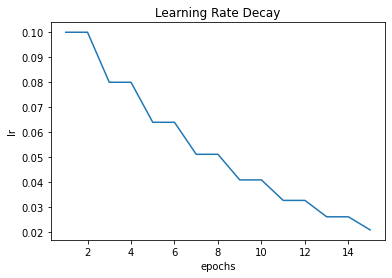

In [23]:
plt.title("Learning Rate Decay")
plt.plot(epochs,lrs)
plt.xlabel("epochs")
plt.ylabel("lr")
plt.show()

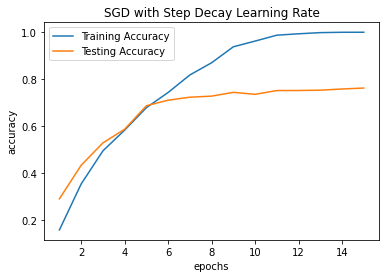

In [24]:
plt.title("SGD with Step Decay Learning Rate")
plt.plot(epochs, train_acc_step_decay, label='Training Accuracy')
plt.plot(epochs, test_acc_step_decay, label='Testing Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# SGD Optimizer: Exponential Decay for Learning Rate



In [25]:
%%time

model = CIFAR10().to(device)

train_acc_exp_decay=[]
test_acc_exp_decay=[]

lrs = []


loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate, momentum=0.5, weight_decay = 0.01/100)
scheduler = ExponentialLR(optimizer, gamma=0.9)
for epoch in range(num_epochs):
    total_training_accuracies = []
    total_testing_accuracies = []
    for img, labels in train_loader:
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        metrics = accuracy_score(pred, labels)
        total_training_accuracies.append(metrics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
    train_acc_exp_decay.append(sum(total_training_accuracies)/len(total_training_accuracies))
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc_exp_decay.append(sum(total_testing_accuracies)/len(total_testing_accuracies))

Epoch Number:  1  | Training Accuracy Score:  tensor(0.1392)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.2676)
Epoch Number:  2  | Training Accuracy Score:  tensor(0.3344)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.4191)
Epoch Number:  3  | Training Accuracy Score:  tensor(0.4872)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.4985)
Epoch Number:  4  | Training Accuracy Score:  tensor(0.6054)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.6391)
Epoch Number:  5  | Training Accuracy Score:  tensor(0.6960)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.6681)
Epoch Number:  6  | Training Accuracy Score:  tensor(0.7610)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.7254)
Epoch Number:  7  | Training Accuracy Score:  tensor(0.8187)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.7694)
Epoch Number:  8  | Training Accuracy Score:  tensor(0.8737)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.7668)
Epoch Number:  9  | Training Acc

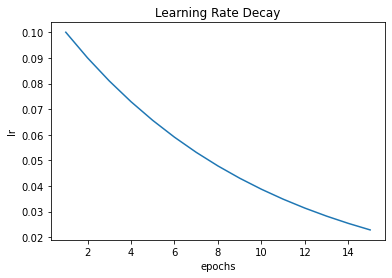

In [26]:
plt.title("Learning Rate Decay")
plt.plot(epochs,lrs)
plt.xlabel("epochs")
plt.ylabel("lr")
plt.show()

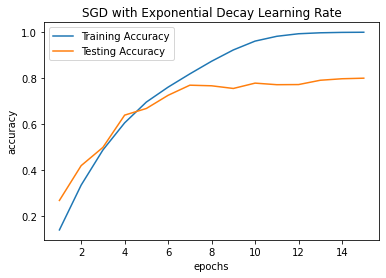

In [27]:
plt.title("SGD with Exponential Decay Learning Rate")
plt.plot(epochs, train_acc_exp_decay, label='Training Accuracy')
plt.plot(epochs, test_acc_exp_decay, label='Testing Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Comparing Exponential & Step Decay

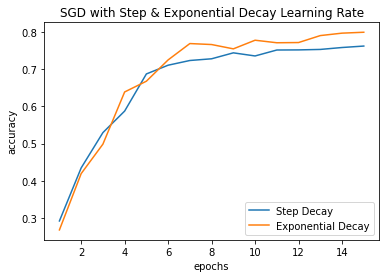

In [33]:
plt.title("SGD with Step & Exponential Decay Learning Rate")
plt.plot(epochs, test_acc_step_decay, label='Step Decay')
plt.plot(epochs, test_acc_exp_decay, label='Exponential Decay')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Comparing Optimizers

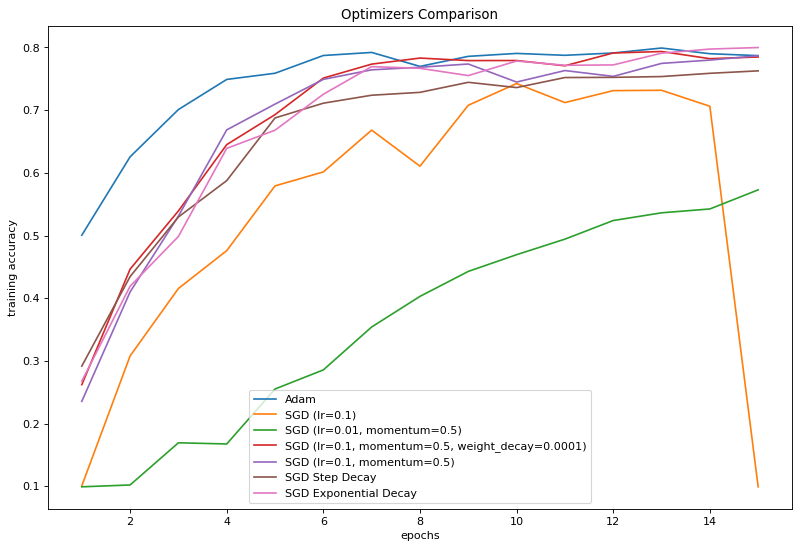

In [28]:
plt.figure(figsize=(12, 8), dpi=80)
plt.title("Optimizers Comparison")
plt.plot(epochs, test_acc_adam, label='Adam')
plt.plot(epochs, test_acc_sgd1, label='SGD (lr=0.1)')
plt.plot(epochs, test_acc_sgd2, label='SGD (lr=0.01, momentum=0.5)')
plt.plot(epochs, test_acc_sgd3, label='SGD (lr=0.1, momentum=0.5, weight_decay=0.0001)')
plt.plot(epochs, test_acc_sgd4, label='SGD (lr=0.1, momentum=0.5)')
# plt.plot(epochs, test_acc_sgd5, label='SGD Time Based Decay')
plt.plot(epochs, test_acc_step_decay, label='SGD Step Decay')
plt.plot(epochs, test_acc_exp_decay, label='SGD Exponential Decay')
plt.xlabel("epochs")
plt.ylabel("training accuracy")
plt.legend()
plt.show()

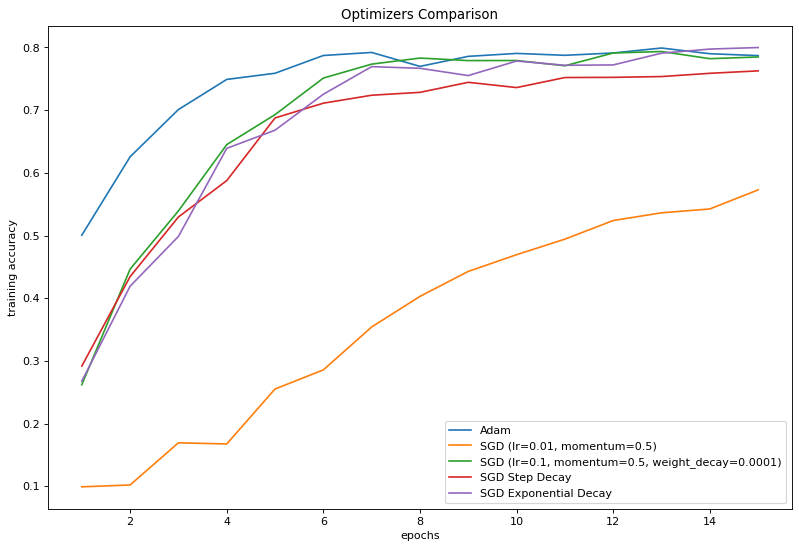

In [34]:
plt.figure(figsize=(12, 8), dpi=80)
plt.title("Optimizers Comparison")
plt.plot(epochs, test_acc_adam, label='Adam')
# plt.plot(epochs, test_acc_sgd1, label='SGD (lr=0.1)')
plt.plot(epochs, test_acc_sgd2, label='SGD (lr=0.01, momentum=0.5)')
plt.plot(epochs, test_acc_sgd3, label='SGD (lr=0.1, momentum=0.5, weight_decay=0.0001)')
# plt.plot(epochs, test_acc_sgd4, label='SGD (lr=0.1, momentum=0.5)')
# plt.plot(epochs, test_acc_sgd5, label='SGD Time Based Decay')
plt.plot(epochs, test_acc_step_decay, label='SGD Step Decay')
plt.plot(epochs, test_acc_exp_decay, label='SGD Exponential Decay')
plt.xlabel("epochs")
plt.ylabel("training accuracy")
plt.legend()
plt.show()